In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.tag import StanfordPOSTagger
from nltk import word_tokenize
from nltk.internals import find_jars_within_path
import nltk
import sklearn.model_selection
from collections import Counter
import sklearn.feature_extraction.text as skt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import io
import re
import string
import tqdm

import pyhealth
from pyhealth.medcode import InnerMap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk

from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score

import gensim.models.word2vec as w2v

import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import tensorflow as TF


/Users/ashleyroakes/opt/anaconda3/envs/Project/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
root = "/Users/ashleyroakes/Desktop/"
#root = "./data/"

mim_root = root + "mimic-iii-clinical-database-1.4/"


# Data Pre-processing
## Read in Discharge Notes

In [3]:
notes = mim_root + "NOTEEVENTS.csv.gz"

notes_df = pd.read_csv(notes, compression='gzip', error_bad_lines=False, 
                       usecols = ['SUBJECT_ID', 'HADM_ID', 'CATEGORY', 'DESCRIPTION','TEXT'])\
                      .query("CATEGORY == 'Discharge summary'")\
                      .query("DESCRIPTION == 'Report'")

# Should be 55,177 records
print("Number of discharge summaries: ", + len(notes_df))

notes_df.head()

Number of discharge summaries:  55177


,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT
0,22532,167853.0,Discharge summary,Report,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,Discharge summary,Report,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,Discharge summary,Report,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,Discharge summary,Report,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,Discharge summary,Report,Admission Date: [**2162-3-3**] D...


## Read in Patient Diagnoses

In [4]:
diag = mim_root + "DIAGNOSES_ICD.csv.gz"

diag_df = pd.read_csv(diag, compression='gzip', error_bad_lines=False)\
                    .dropna()\
                    .groupby('HADM_ID')['ICD9_CODE']\
                    .unique()\
                    .reset_index()

diag_df.head()

,HADM_ID,ICD9_CODE
0,100001,"[25013, 3371, 5849, 5780, V5867, 25063, 5363, ..."
1,100003,"[53100, 2851, 07054, 5715, 45621, 53789, 4019,..."
2,100006,"[49320, 51881, 486, 20300, 2761, 7850, 3090, V..."
3,100007,"[56081, 5570, 9973, 486, 4019]"
4,100009,"[41401, 99604, 4142, 25000, 27800, V8535, 4148..."


## Read in ICD9 Dictionary

In [5]:
icd = mim_root + "D_ICD_DIAGNOSES.csv.gz"
icd_df = pd.read_csv(icd, compression='gzip', error_bad_lines=False)


icd_df.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


## Merge datasets by HADM_ID

In [6]:
df = pd.merge(diag_df, notes_df, on='HADM_ID', how='inner')

# Should be 55177-5 = 55172
len(df)

55172

## Substitute special sequences & Filter HoPI sections

### Identify HOPI sections & Substitute Special Sequences

In [7]:
def process_notes(st):
    s  = "History of Present Illness"
    s1 = "HISTORY OF PRESENT ILLNESS|HISTORY OF THE PRESENT ILLNESS|\nHISTORY:|present illness|Present Illness|PRESENT ILLNESS"
    
    match  = re.search(s, st)
    match1 = re.search(s1, st)
    
    if (match is not None) or (match1 is not None):
        if match is not None:
            st = st.split(s, 1)[1]
            e = "\n\n\n"
            n = st.split(e, 1)[0]
    
        elif match1 is not None: 
            st = st.split(match1[0], 1)[1]
            e = re.search(r"\n[\s\w]+:", st)[0]
            n = st.split(e, 1)[0]
        
        # Replace special strings with ""
        rep = re.findall(r"\[\*\*([a-zA-Z0-9]*)", n)
        strt = [m.start() for m in re.finditer("\[\*\*([a-zA-Z0-9]*)", n)]
        end = [m.end() for m in re.finditer("([a-zA-Z0-9]*)\*\*\]", n)]

        for i in range(len(rep)):
            n = n[:strt[i]] + rep[i] + " " + n[end[i] + 1:]
        
    else: 
        n = ''
    return n

In [8]:
df['HOPI'] = df["TEXT"].map(lambda t: process_notes(t))

df["HOPI"] = df["HOPI"].apply(lambda x: re.sub('\[\*\*[^\]]*\*\*\]', '', x))
df["HOPI"] = df["HOPI"].apply(lambda x: re.sub('<[^>]*>', '', x))
df["HOPI"] = df["HOPI"].apply(lambda x: re.sub('[\W]+', ' ', x))

# Detect history of present illness in text (n = 2641 records without HoPI data)
missing = len(df[df['HOPI'] == ""])
print("Number of docs missing HOPI sections: " + str(missing))

df = df[df["HOPI"] != ""].reset_index(drop = True)
df['SENT_TOKENS'] = df["HOPI"].map(lambda t: [p.lower() for p in nltk.RegexpTokenizer(r'\w+').tokenize(t) if not p.isnumeric()])


Number of docs missing HOPI sections: 1867


In [9]:
# Truncate to 500 tokens per HOPI
df["SENT_TOKENS"] = df["SENT_TOKENS"].map(lambda c: np.unique(c)[0:500])

df['SENT_TOKENS_COMBO'] = df["SENT_TOKENS"].map(lambda t: " ".join(t))
df.head()

,HADM_ID,ICD9_CODE,SUBJECT_ID,CATEGORY,DESCRIPTION,TEXT,HOPI,SENT_TOKENS,SENT_TOKENS_COMBO
0,100001,"[25013, 3371, 5849, 5780, V5867, 25063, 5363, ...",58526,Discharge summary,Report,Admission Date: [**2117-9-11**] ...,35F w poorly controlled Type 1 diabetes melli...,"[325mg, 35f, 3l, 3rd, 4mg, 5d, a, ag, also, am...",325mg 35f 3l 3rd 4mg 5d a ag also am an and an...
1,100003,"[53100, 2851, 07054, 5715, 45621, 53789, 4019,...",54610,Discharge summary,Report,Admission Date: [**2150-4-17**] ...,Mr Known is a 59M w HepC cirrhosis c b grade ...,"[40mg, 4l, 59m, a, abdominal, about, abstain, ...",40mg 4l 59m a abdominal about abstain admissio...
2,100006,"[49320, 51881, 486, 20300, 2761, 7850, 3090, V...",9895,Discharge summary,Report,Admission Date: [**2108-4-6**] Discharg...,This is a 48 year old African American female...,"[a, abdominal, abg, admitted, african, ago, al...",a abdominal abg admitted african ago albuterol...
3,100007,"[56081, 5570, 9973, 486, 4019]",23018,Discharge summary,Report,Admission Date: [**2145-3-31**] ...,Ms Known is a 73 year old female with a histo...,"[a, abdominal, and, appendectomy, back, began,...",a abdominal and appendectomy back began bowel ...
4,100009,"[41401, 99604, 4142, 25000, 27800, V8535, 4148...",533,Discharge summary,Report,Admission Date: [**2162-5-16**] ...,60yo man with known coronary disease AMI in 2...,"[36mmhg, 60yo, a, admitted, ak, ami, and, angi...",36mmhg 60yo a admitted ak ami and angina anter...


In [10]:
sentences = df['SENT_TOKENS_COMBO'].map(lambda t: t.split()).values

model = w2v.Word2Vec(vector_size=200, min_count=5, workers=4, epochs=5)

model.build_vocab(sentences)

model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

model.save('./model/model.w2v')

wv = model.wv

vocab = model.wv.key_to_index  

ind2w = {i+1:w for i,w in enumerate(sorted(vocab))}
w2ind = {w:i for i,w in ind2w.items()}

PAD_CHAR = "**PAD**"

def build_matrix(ind2w, wv):
    W = np.zeros((len(ind2w)+1, len(wv.get_vector(wv.index_to_key[0])) ))
    words = [PAD_CHAR]
    W[0][:] = np.zeros(len(wv.get_vector(wv.index_to_key[0])))
    for idx, word in ind2w.items():
        if idx >= W.shape[0]:
            break    
        W[idx][:] = wv.get_vector(word)
        words.append(word)
    return W, words

W, words = build_matrix(ind2w, wv)

def save_embeddings(W, words, outfile):
    with open(outfile, 'w') as o:
        #pad token already included
        for i in range(len(words)):
            line = [words[i]]
            line.extend([str(d) for d in W[i]])
            o.write(" ".join(line) + "\n")

outfile = './model/model.embed'
save_embeddings(W, words, outfile)


Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=200, alpha=0.025>', 'datetime': '2022-11-26T21:29:37.180194', 'gensim': '4.2.0', 'python': '3.8.15 (default, Nov 10 2022, 13:17:42) \n[Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
PROGRESS: at sentence #10000, processed 1408781 words, keeping 57207 word types
PROGRESS: at sentence #20000, processed 2815360 words, keeping 88177 word types
PROGRESS: at sentence #30000, processed 4222394 words, keeping 113580 word types
PROGRESS: at sentence #40000, processed 5641322 words, keeping 136651 word types
PROGRESS: at sentence #50000, processed 7042111 words, keeping 157550 word types
collected 164182 word types from a corpus of 7512332 raw words and 53305 sentences
Creating a fresh vocabulary
Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 27703 unique words (16.87% of orig

In [11]:
def load_embeddings(embed_file):
    #also normalizes the embeddings
    W = []
    with open(embed_file) as ef:
        for line in ef:
            line = line.rstrip().split()
            vec = np.array(line[1:]).astype(float)
            vec = vec / float(np.linalg.norm(vec) + 1e-6)
            W.append(vec)
        vec = np.random.randn(len(W[-1]))
        vec = vec / float(np.linalg.norm(vec) + 1e-6)
        W.append(vec)
    W = np.array(W)
    return W

loaded_embed = torch.Tensor(load_embeddings(outfile))

embed = nn.Embedding(loaded_embed.size()[0], loaded_embed.size()[1], padding_idx=0)
embed.weight.data = loaded_embed.clone()

In [12]:
# adding indexes
df["idx_tokens"] = df['SENT_TOKENS'].map(lambda t: [int(w2ind[w]) if w in w2ind else len(w2ind)+1 for w in t])
df.head(5)

,HADM_ID,ICD9_CODE,SUBJECT_ID,CATEGORY,DESCRIPTION,TEXT,HOPI,SENT_TOKENS,SENT_TOKENS_COMBO,idx_tokens
0,100001,"[25013, 3371, 5849, 5780, V5867, 25063, 5363, ...",58526,Discharge summary,Report,Admission Date: [**2117-9-11**] ...,35F w poorly controlled Type 1 diabetes melli...,"[325mg, 35f, 3l, 3rd, 4mg, 5d, a, ag, also, am...",325mg 35f 3l 3rd 4mg 5d a ag also am an and an...,"[631, 657, 712, 730, 872, 1003, 1443, 2090, 23..."
1,100003,"[53100, 2851, 07054, 5715, 45621, 53789, 4019,...",54610,Discharge summary,Report,Admission Date: [**2150-4-17**] ...,Mr Known is a 59M w HepC cirrhosis c b grade ...,"[40mg, 4l, 59m, a, abdominal, about, abstain, ...",40mg 4l 59m a abdominal about abstain admissio...,"[763, 863, 992, 1443, 1592, 1641, 27704, 1973,..."
2,100006,"[49320, 51881, 486, 20300, 2761, 7850, 3090, V...",9895,Discharge summary,Report,Admission Date: [**2108-4-6**] Discharg...,This is a 48 year old African American female...,"[a, abdominal, abg, admitted, african, ago, al...",a abdominal abg admitted african ago albuterol...,"[1443, 1592, 1606, 1985, 2072, 2126, 2220, 231..."
3,100007,"[56081, 5570, 9973, 486, 4019]",23018,Discharge summary,Report,Admission Date: [**2145-3-31**] ...,Ms Known is a 73 year old female with a histo...,"[a, abdominal, and, appendectomy, back, began,...",a abdominal and appendectomy back began bowel ...,"[1443, 1592, 2550, 2886, 3682, 3884, 4456, 561..."
4,100009,"[41401, 99604, 4142, 25000, 27800, V8535, 4148...",533,Discharge summary,Report,Admission Date: [**2162-5-16**] ...,60yo man with known coronary disease AMI in 2...,"[36mmhg, 60yo, a, admitted, ak, ami, and, angi...",36mmhg 60yo a admitted ak ami and angina anter...,"[671, 1078, 1443, 1985, 2188, 2390, 2550, 2611..."


## Plot a histogram of the Number of tokens in each HoPI document, after data preprocessing.

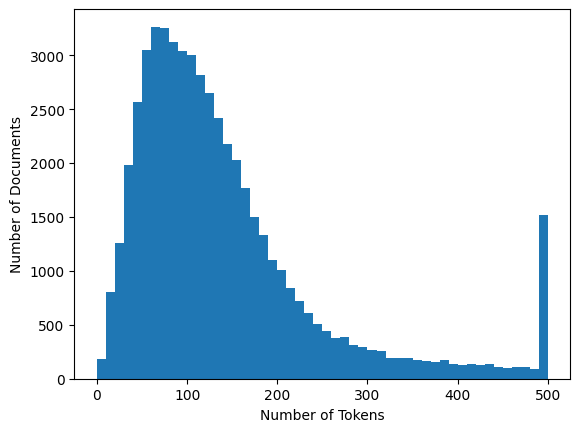

In [13]:
df["trunc_len"] = df['SENT_TOKENS'].map(lambda c: len(c))

plt.hist(df["trunc_len"], np.arange(0, 501, 10))
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Documents")
plt.show()

## Split data in train, valid, and test sets
### training (38,588 records, 69.9%), validation (5536 records, 10.0%) and testing (11,048 records, 20.0%) folds

In [16]:
# Random split
train, tst = sklearn.model_selection.train_test_split(df, test_size= 0.3, random_state=42)

test, valid = sklearn.model_selection.train_test_split(tst, test_size= 0.33, random_state=42)

train = train.reset_index(drop = True).drop(["CATEGORY", "DESCRIPTION"], axis = 1)
test = test.reset_index(drop = True).drop(["CATEGORY", "DESCRIPTION"], axis = 1)
valid = valid.reset_index(drop = True).drop(["CATEGORY", "DESCRIPTION"], axis = 1)

print(f"Length of training: {len(train)}, length of test: {len(test)}, & length of valid: {len(valid)}")

Length of training: 37313, length of test: 10714, & length of valid: 5278


## Count number of tokens in the training dataset (n = ~92,468 tokens)

In [17]:
# Count occurence of tokens that are in the training dataset
n = len(np.unique(np.concatenate(train['SENT_TOKENS'].values)))
occ = Counter(np.concatenate(train['SENT_TOKENS'].values))
            
# Tokens that occur >= 5 times are in the study vocabulary (should be ~19,503)
vocab = [k for k,v in occ.items() if v >= 5]
print(len(vocab))

# Assign a unique integer ID for each token in the study vocabulary 
vocab_lookup = dict(zip(vocab, np.arange(0, len(vocab), 1)))

# Convert each HoPI document to a 1D array of integers using this index
train["trunc_idx"] =  train['SENT_TOKENS'].map(lambda x: [vocab_lookup.get(i) for i in x if i in vocab_lookup.keys()])
valid["trunc_idx"] =  valid['SENT_TOKENS'].map(lambda x: [vocab_lookup.get(i) for i in x if i in vocab_lookup.keys()])
test["trunc_idx"] =  test['SENT_TOKENS'].map(lambda x: [vocab_lookup.get(i) for i in x if i in vocab_lookup.keys()])

22744


# Document representation

In [18]:
# Represent clinical notes documents as TF-IDF weights
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

def tfidf(df):
    pipe = Pipeline([('count', CountVectorizer(vocabulary = vocab, lowercase = False)),('tfid', TfidfTransformer(use_idf=True))]).fit(df["HOPI"].values)
    pipe['count'].transform(df["HOPI"].values).toarray()
    pipe['tfid'].idf_

    return pipe.transform(df["HOPI"].values)

# Create sparse matrix of size number of docs x words in vocab
tfidf_train = tfidf(train)
tfidf_valid = tfidf(valid)
tfidf_test = tfidf(test)

In [14]:
# Document embedding representation
xemb_train = train['idx_tokens'].map(lambda t: [np.array(embed.weight.data[w]) for w in t])
xemb_valid = valid['idx_tokens'].map(lambda t: [np.array(embed.weight.data[w]) for w in t])
xemb_test = test['idx_tokens'].map(lambda t: [np.array(embed.weight.data[w]) for w in t])

# Document mean embedding representation
xmean_train = train['idx_tokens'].map(lambda t: np.average([np.array(embed.weight.data[w]) for w in t], axis = 0))
xmean_valid = valid['idx_tokens'].map(lambda t: np.average([np.array(embed.weight.data[w]) for w in t], axis = 0))
xmean_test = test['idx_tokens'].map(lambda t: np.average([np.array(embed.weight.data[w]) for w in t], axis = 0))

NameError: name 'train' is not defined

In [20]:
# GRU representation



# Label representation

### Identify the hierarchical labels for each icd9 code

In [21]:
# Pull out the main ICD9 code (they are ordered for importance)
train["ICD_Main"] = train['ICD9_CODE'].map(lambda x: x[0])
valid["ICD_Main"] = valid['ICD9_CODE'].map(lambda x: x[0])
test["ICD_Main"] = test['ICD9_CODE'].map(lambda x: x[0])

In [22]:
# Use Pyhealth library to find code hierarchy for the train, test, and valid datasets
icd9cm = InnerMap.load("ICD9CM")

def define_levels(x):
    lvls = []
    for l in x: 
        lvls.append(icd9cm.lookup(l))
    return lvls

def drop_top(X):
    if '001-999.99' in X:
        X.remove('001-999.99')
    return X

def get_codes(df):
    #df['icd_desc'] = df['ICD_Main'].map(lambda x: icd9cm.lookup(x))
    df['levels'] = df['ICD_Main'].map(lambda x:icd9cm.get_ancestors(x)[::-1])
    df['levels'].map(lambda x: drop_top(x))

    for i in range(len(df)):
        df['levels'][i].append(df['ICD_Main'][i])

    df['levels_desc'] = df['levels'].map(lambda x: define_levels(x))

get_codes(train)
get_codes(valid)
get_codes(test)

In [23]:
# Append the code descriptions to the dfs
train_labs = pd.concat([train, train['levels_desc'].apply(pd.Series)], axis = 1).drop("levels_desc", axis = 1)\
    .rename(columns={0: "y_l1", 1: "y_l2", 2: "y_l3", 3: "y_l4", 4:"y_l5", 5:"y_l6"})
valid_labs = pd.concat([valid, valid['levels_desc'].apply(pd.Series)], axis = 1).drop("levels_desc", axis = 1)\
    .rename(columns={0: "y_l1", 1: "y_l2", 2: "y_l3", 3: "y_l4", 4:"y_l5", 5:"y_l6"})
test_labs = pd.concat([test, test['levels_desc'].apply(pd.Series)], axis = 1).drop("levels_desc", axis = 1)\
    .rename(columns={0: "y_l1", 1: "y_l2", 2: "y_l3", 3: "y_l4" , 4:"y_l5", 5:"y_l6"})

In [24]:
# Mean representation 

## Baseline Model: TFIDF-Atomic

#### TFIDF document weights were input into a multinomial logistic regression classifier in order to predict the 4 levels of icd hierarchy

### Predict level 1 icd9 codes

In [142]:
# Multinomial Logistic Regression from sklearn 

# L2 values to iterate over
L2 = np.logspace(.01, 100, num = 50)
L2 = [1.023292992280754]

# # Enumerate the l1 classes
y_l1_dict = dict(zip(np.unique(train_labs['y_l1'].values), np.arange(0, len(np.unique(train_labs['y_l1'].values)), 1)))
y_l1_trn = train_labs['y_l1'].map(lambda x: y_l1_dict.get(x))
y_l1_val = valid_labs['y_l1'].map(lambda x: y_l1_dict.get(x))
y_l1_tst = test_labs['y_l1'].map(lambda x: y_l1_dict.get(x))

def log_reg_val(y_trn, y_val, x_trn, x_val, L2):
    
    # Use the validation data to determine the best model parameter for C
    scores = []
    i = 1
    for C in L2: 
        if len(L2)%(i) == 0:
            print(f"Validation Progress: {i/len(L2)*100} %")

        tfidf_atomic = LogisticRegression(multi_class = 'multinomial', penalty = 'l2', max_iter = 1500, solver = "sag", random_state = 42, C = C)
        tfidf_atomic_L1 = tfidf_atomic.fit(x_trn, y_trn)
        y_v_pred = tfidf_atomic_L1.predict(x_val)
        report = metrics.classification_report(y_val, y_v_pred, digits = 3, output_dict=True)
        scores.append((C, report['weighted avg']['recall']))

    # C value for best model on valid data
    best_C = max(scores,key=lambda x:x[1])[0]
    return best_C

best_C = log_reg_val(x_trn = tfidf_train, y_trn = y_l1_trn, L2 = L2, y_val = y_l1_val, x_val = tfidf_valid)

# Get results on test data for best model
tfidf_atomic = LogisticRegression(multi_class = 'multinomial', penalty = 'l2', max_iter = 1500, solver = "sag", random_state = 42, C = best_C)
tfidf_atomic_l1 = tfidf_atomic.fit(tfidf_train, y_l1_trn)
y_pred = tfidf_atomic_l1.predict(tfidf_test)
L1_test_report = metrics.classification_report(y_l1_tst, y_pred, digits = 3, output_dict=True)
L1_test_report['weighted avg']

Validation Progress: 100.0 %


{'precision': 0.6668932390234398,
 'recall': 0.6768713832368863,
 'f1-score': 0.6521999221367677,
 'support': 10714}

In [26]:
#BEST C Found for tfidf tier1: 1.023292992280754
print(f'best C for tfidf tier1: {best_C}')

best C for tfidf tier1: 1.023292992280754


### Predict level 2 icd9 codes

In [143]:
# Multinomial Logistic Regression from sklearn 

# L2 values to iterate over; in order to run all iterations uncomment the line below
#L2 = np.logspace(.01, 100, num = 50)
L2 = [1.023292992280754] # This was the best C value out of the 50

# Enumerate the l2 classes
y_l2_dict = dict(zip(np.unique(train_labs['y_l2'].values), np.arange(0, len(np.unique(train_labs['y_l2'].values)), 1)))
y_l2_trn = train_labs['y_l2'].map(lambda x: y_l2_dict.get(x)).fillna('Missing')
y_l2_val = valid_labs['y_l2'].map(lambda x: y_l2_dict.get(x)).fillna('Missing')
y_l2_tst = test_labs['y_l2'].map(lambda x: y_l2_dict.get(x)).fillna('Missing')

# Only include lvl2 labels that are in the training set
tst_miss = [y_l2_tst != "Missing"]
tst_idx_2 = np.where(y_l2_tst != 'Missing')
y_l2_tst = np.array(y_l2_tst[y_l2_tst != "Missing"]).astype(int)

val_miss = [y_l2_val != "Missing"]
val_idx_2 = np.where(y_l2_val != 'Missing')
y_l2_val = np.array(y_l2_val[y_l2_val != "Missing"]).astype(int)

best_C = log_reg_val(x_trn = tfidf_train, y_trn = y_l2_trn, L2 = L2, y_val = y_l2_val, x_val = tfidf_valid[list(val_idx_2[0]), :])

# Get results on test data for best model
tfidf_atomic = LogisticRegression(multi_class = 'multinomial', penalty = 'l2', max_iter = 1500, solver = "sag", random_state = 42, C = best_C)
tfidf_atomic_l2 = tfidf_atomic.fit(tfidf_train, y_l2_trn)
y_pred = tfidf_atomic_l2.predict(tfidf_test[list(tst_idx_2[0]), :])
L2_test_report = metrics.classification_report(y_l2_tst, y_pred, digits = 3, output_dict=True)
L2_test_report['weighted avg']

Validation Progress: 100.0 %


{'precision': 0.529786295283573,
 'recall': 0.5524227429745122,
 'f1-score': 0.513553821091097,
 'support': 10711}

In [144]:
# BEST C Found for tfidf tier2: 1.023292992280754
print(f'best C for tfidf tier2: {best_C}')

best C for tfidf tier2: 1.023292992280754


### Predict level 3 icd9 codes

In [224]:
# Multinomial Logistic Regression from sklearn 

# L2 values to iterate over; in order to run all iterations uncomment the line below
# L2 = np.logspace(.01, 100, num = 50)
L2 = [1.023292992280754]

# Enumerate the l3 classes
train_miss = train_labs['y_l3'].isna()
train_labs_l3 = train_labs[~train_miss]
y_l3_dict = dict(zip(set(train_labs_l3['y_l3'].values), np.arange(0, len(set(train_labs_l3['y_l3'].values)), 1)))

y_l3_trn = train_labs_l3['y_l3'].map(lambda x: y_l3_dict.get(x)).fillna('Missing')
y_l3_val = valid_labs['y_l3'].map(lambda x: y_l3_dict.get(x)).fillna('Missing')
y_l3_tst = test_labs['y_l3'].map(lambda x: y_l3_dict.get(x)).fillna('Missing')

# Only include lvl2 labels that are in the training set
tst_miss = [y_l3_tst != "Missing"]
tst_idx_3 = np.where(y_l3_tst != 'Missing')
y_l3_tst = np.array(y_l3_tst[y_l3_tst != "Missing"]).astype(int)

val_miss = [y_l3_val != "Missing"]
val_idx_3 = np.where(y_l3_val != 'Missing')
y_l3_val = np.array(y_l3_val[y_l3_val != "Missing"]).astype(int)

best_C = log_reg_val(x_trn = tfidf_train[~train_miss,:], y_trn = y_l3_trn, L2 = L2, y_val = y_l3_val, x_val = tfidf_valid[list(val_idx_3[0]), :])

# Get results on test data for best model
tfidf_atomic = LogisticRegression(multi_class = 'multinomial', penalty = 'l2', max_iter = 1500, solver = "sag", random_state = 42, C = best_C)
tfidf_atomic_l3 = tfidf_atomic.fit(tfidf_train[~train_miss,:], y_l3_trn)
y_pred = tfidf_atomic_l3.predict(tfidf_test[list(tst_idx_3[0]), :])
L3_test_report = metrics.classification_report(y_l3_tst, y_pred, digits = 3, output_dict=True)
L3_test_report['weighted avg']

Validation Progress: 100.0 %


{'precision': 0.39221832038164023,
 'recall': 0.44016493299597037,
 'f1-score': 0.38074887974566596,
 'support': 10671}

In [146]:
# BEST C Found for tfidf tier3:
print(f'best C for tfidf tier3: {best_C}')

best C for tfidf tier3: 1.023292992280754


### Predict terminal icd9 codes

In [279]:
# Multinomial Logistic Regression from sklearn 

# L2 values to iterate over; in order to run all iterations uncomment the line below
# L2 = np.logspace(.01, 100, num = 10)
L2 = [1.023292992280754]

# Due to long training time; only predict a subset of the level 4 classes
train_labs_l4 = train_labs[~train_labs['y_l4'].isna()]

# Get top X number of classes in the training data
train_top = train_labs_l4['y_l4'].value_counts()[0:32]

# 16,869 data points after filtering for the top 32 classes 
train_labs_l4 = train_labs[train_labs['y_l4'].isin(list(train_top.index))]

y_l4_dict = dict(zip(set(train_labs_l4['y_l4'].values), np.arange(0, len(set(train_labs_l4['y_l4'].values)), 1)))

train_labs_l4 = train_labs_l4[train_labs['y_l4'].isin(list(train_top.index))]

train_idx_4 = np.where(~train_labs_l4['y_l4'].isna())
train_labs_l4 = train_labs_l4[~train_labs_l4['y_l4'].isna()]

# Remove classes that are not in the dictionary
y_l4_trn = train_labs_l4['y_l4'].map(lambda x: y_l4_dict.get(x)).fillna('Missing')
y_l4_val = valid_labs['y_l4'].map(lambda x: y_l4_dict.get(x)).fillna('Missing')
y_l4_tst = test_labs['y_l4'].map(lambda x: y_l4_dict.get(x)).fillna('Missing')

# Only include labels that are in the training set
tst_miss = [y_l4_tst != "Missing"]
tst_idx_4 = np.where(y_l4_tst != 'Missing')
y_l4_tst = np.array(y_l4_tst[y_l4_tst != "Missing"]).astype(int)

# Only include labels that are in the training set
val_miss = [y_l4_val != "Missing"]
val_idx_4 = np.where(y_l4_val != 'Missing')
y_l4_val = np.array(y_l4_val[y_l4_val != "Missing"]).astype(int)

# Test different l2 regularization coefficiants on the validation dataset 
best_C = log_reg_val(x_trn = tfidf_train[train_idx_4[0],:], y_trn = y_l4_trn, L2 = L2, y_val = y_l4_val, x_val = tfidf_valid[list(val_idx_4[0]), :])

# Get results on test data for best model
tfidf_atomic = LogisticRegression(multi_class = 'multinomial', penalty = 'l2', max_iter = 1500, solver = "sag", random_state = 42, C = best_C)
tfidf_atomic_l4 = tfidf_atomic.fit(tfidf_train[~train_idx_4[0],:], y_l4_trn)
y_pred = tfidf_atomic_l4.predict(tfidf_test[tst_idx_4[0], :])
L4_test_report = metrics.classification_report(y_l4_tst, y_pred, digits = 3, output_dict=True)
L4_test_report['weighted avg']

Validation Progress: 100.0 %


{'precision': 0.047441373457230776,
 'recall': 0.12740434332988623,
 'f1-score': 0.05233019613665538,
 'support': 4835}

## Mean-atomic

### The mean embedding representation for the documents was input into a tensorflow softmax classifier to represent the labels atomically

### Precict level 1 icd9 codes

In [160]:
import tensorflow.compat.v1 as tf
from sklearn import preprocessing

# number of features
num_features = 200

# number of target labels
num_labels = len(np.unique(y_l1_trn))

# learning rate (alpha)
learning_rate = 0.003

# batch size
batch_size = 128

# number of epochs
num_steps = 5000

def one_hot(y, c):
    
    # y--> label/ground truth.
    # c--> Number of classes.
    
    # A zero matrix of size (m, c)
    y_hot = np.zeros((len(y), c))
    
    # Putting 1 for column where the label is,
    # Using multidimensional indexing.
    y_hot[np.arange(len(y)), y] = 1
    
    return y_hot
  
# input data
train_dataset = preprocessing.normalize(np.array(pd.DataFrame(xmean_train)['idx_tokens'].apply(pd.Series)))
train_labels = one_hot(y_l1_trn, num_labels)
test_dataset = preprocessing.normalize(np.array(pd.DataFrame(xmean_test)['idx_tokens'].apply(pd.Series)))
test_labels = one_hot(y_l1_tst, num_labels)
valid_dataset = preprocessing.normalize(np.array(pd.DataFrame(xmean_valid)['idx_tokens'].apply(pd.Series)))
valid_labels = one_hot(y_l1_val, num_labels)
  
def nn_softmax(train_dataset, train_labels, test_dataset, test_labels, valid_dataset, valid_labels, num_features, batch_size, num_labels, num_steps, learning_rate):
    # initialize a tensorflow graph
    graph = tf.Graph()
  
    with graph.as_default():
        """
        defining all the nodes
        """
    
        # Inputs
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, num_features))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)
    
        # Variables.
        weights = tf.Variable(tf.truncated_normal([num_features, num_labels]))
        biases = tf.Variable(tf.zeros([num_labels]))
    
        # Training computation.
        logits = tf.matmul(tf_train_dataset, weights) + biases
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                            labels=tf_train_labels, logits=logits))
    
        # Optimizer.
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
        test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

    # utility function to calculate F1, precision, recall
    def sm_metrics(predictions, labels):
        y_pred = np.argmax(predictions, axis=1)
        y_labs = np.argmax(labels, axis=1)
        f1 = f1_score(y_labs, y_pred, average = 'weighted')
        prec = precision_score(y_labs, y_pred, average = 'weighted')
        rec = recall_score(y_labs, y_pred, average = 'weighted')
        return f1, prec, rec
    
    with tf.Session(graph=graph) as session:
        # initialize weights and biases
        tf.global_variables_initializer().run()
        print("Initialized")
    
        for step in range(num_steps):
            # pick a randomized offset
            offset = np.random.randint(0, train_labels.shape[0] - batch_size - 1)
    
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
    
            # Prepare the feed dict
            feed_dict = {tf_train_dataset : batch_data,
                        tf_train_labels : batch_labels}
    
            # run one step of computation
            _, l, predictions = session.run([optimizer, loss, train_prediction],
                                            feed_dict=feed_dict)
    
        print("\n Test F1 Score: {:.3f}".format(
            sm_metrics(test_prediction.eval(), test_labels)[0]))
        print("\n Test Precision: {:.3f}".format(
            sm_metrics(test_prediction.eval(), test_labels)[1]))
        print("\n Test Recall: {:.3f}".format(
            sm_metrics(test_prediction.eval(), test_labels)[2]))

nn_softmax(train_dataset, train_labels, test_dataset, test_labels, valid_dataset, valid_labels, num_features, batch_size, num_labels, num_steps, learning_rate)

Initialized

 Test F1 Score: 0.544

 Test Precision: 0.553

 Test Recall: 0.582


### Precict level 2 icd9 codes

In [153]:
# number of features
num_features = 200

# number of target labels
num_labels = len(np.unique(y_l2_trn))

# learning rate (alpha)
learning_rate = 0.003

# batch size
batch_size = 128

# number of epochs
num_steps = 5000
  
# input data
train_dataset = preprocessing.normalize(np.array(pd.DataFrame(xmean_train)['idx_tokens'].apply(pd.Series)))
train_labels = one_hot(y_l2_trn, num_labels)
test_dataset = preprocessing.normalize(np.array(pd.DataFrame(xmean_test[tst_idx_2[0]])['idx_tokens'].apply(pd.Series)))
test_labels = one_hot(y_l2_tst, num_labels)
valid_dataset = preprocessing.normalize(np.array(pd.DataFrame(xmean_valid[val_idx_2[0]])['idx_tokens'].apply(pd.Series)))
valid_labels = one_hot(y_l2_val, num_labels)

nn_softmax(train_dataset, train_labels, test_dataset, test_labels, valid_dataset, valid_labels, num_features, batch_size, num_labels, num_steps, learning_rate)  

Initialized

 Test F1 Score: 0.362

 Test Precision: 0.360

 Test Recall: 0.413


### Precict level 3 icd9 codes

In [240]:
# number of features
num_features = 200

# number of target labels
num_labels = len(np.unique(y_l3_trn))

# learning rate (alpha)
learning_rate = 0.003

# batch size
batch_size = 128

# number of epochs
num_steps = 5000

train_idx = np.where(train_miss != True)
  
# input data
train_dataset = preprocessing.normalize(np.array(pd.DataFrame(xmean_train[train_idx[0]])['idx_tokens'].apply(pd.Series)))
train_labels = one_hot(y_l3_trn, num_labels)
test_dataset = preprocessing.normalize(np.array(pd.DataFrame(xmean_test[tst_idx_3[0]])['idx_tokens'].apply(pd.Series)))
test_labels = one_hot(y_l3_tst, num_labels)
valid_dataset = preprocessing.normalize(np.array(pd.DataFrame(xmean_valid[val_idx_3[0]])['idx_tokens'].apply(pd.Series)))
valid_labels = one_hot(y_l3_val, num_labels)

nn_softmax(train_dataset, train_labels, test_dataset, test_labels, valid_dataset, valid_labels, num_features, batch_size, num_labels, num_steps, learning_rate)  

Initialized

 Test F1 Score: 0.240

 Test Precision: 0.236

 Test Recall: 0.300


### Precict terminal icd9 codes

In [284]:
# number of features
num_features = 200

# number of target labels
num_labels = len(np.unique(y_l4_trn))

# learning rate (alpha)
learning_rate = 0.003

# batch size
batch_size = 128

# number of epochs
num_steps = 5000

train_idx_4 = np.where(~train_labs_l4['y_l4'].isna())
train_labs_l4 = train_labs_l4[~train_labs_l4['y_l4'].isna()]

y_l4_dict = dict(zip(set(train_labs_l4['y_l4'].values), np.arange(0, len(set(train_labs_l4['y_l4'].values)), 1)))

# Remove classes that are not in the dictionary
y_l4_trn = train_labs_l4['y_l4'].map(lambda x: y_l4_dict.get(x)).fillna('Missing')
y_l4_val = valid_labs['y_l4'].map(lambda x: y_l4_dict.get(x)).fillna('Missing')
y_l4_tst = test_labs['y_l4'].map(lambda x: y_l4_dict.get(x)).fillna('Missing')

# Only include labels that are in the training set
tst_idx_4 = np.where(y_l4_tst != 'Missing')
y_l4_tst = np.array(y_l4_tst[y_l4_tst != "Missing"]).astype(int)

# Only include labels that are in the training set
val_idx_4 = np.where(y_l4_val != 'Missing')
y_l4_val = np.array(y_l4_val[y_l4_val != "Missing"]).astype(int)
  
# input data
train_dataset = preprocessing.normalize(np.array(pd.DataFrame(xmean_train[train_idx_4[0]])['idx_tokens'].apply(pd.Series)))
train_labels = one_hot(y_l4_trn, num_labels)
test_dataset = preprocessing.normalize(np.array(pd.DataFrame(xmean_test[tst_idx_4[0]])['idx_tokens'].apply(pd.Series)))
test_labels = one_hot(y_l4_tst, num_labels)
valid_dataset = preprocessing.normalize(np.array(pd.DataFrame(xmean_valid[val_idx_4[0]])['idx_tokens'].apply(pd.Series)))
valid_labels = one_hot(y_l4_val, num_labels)

nn_softmax(train_dataset, train_labels, test_dataset, test_labels, valid_dataset, valid_labels, num_features, batch_size, num_labels, num_steps, learning_rate)  


Initialized

 Test F1 Score: 0.044

 Test Precision: 0.035

 Test Recall: 0.139


## GRU(X) - Mean(z)

### Predict level 1 icd codes

In [172]:
# Mean representation of labels 

### Precict level 2 icd9 codes

### Precict level 3 icd9 codes

### Precict terminal icd9 codes

## GRU(X) - atomic

In [15]:
# GRU with softmax activation
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Variable(xemb_train, requires_grad = False)

# Pad the word embeddings so that they are all the same length
t = pad_sequences([torch.tensor(x) for x in df['idx_tokens']], padding='post')
df['pad_idx'] = t.tolist()
df['emb_tokens'] = df['pad_idx'].map(lambda t: [np.array(embed.weight.data[w]) for w in t])
#df["stack_emb_tokens"] = df['emb_tokens'].map(lambda t: torch.stack(t, dim = 0))


#len(df['idx_tokens'])
# Initialize bi-directional GRU (ref: https://gist.github.com/ceshine/bed2dadca48fe4fe4b4600ccce2fd6e1)
#bi_grus = torch.nn.GRU(input_size = len(train), hidden_size = 1, num_layers = 1, batch_first = False, bidirectional = True)

#bi_output, bi_hidden = bi_grus(xemb_train)


# Using Gated Recurrent Unit
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim),
#     tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
#     tf.keras.layers.Dense(6, activation='relu'),  
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.summary()

# num_epochs = 10
# history_gru = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test))


## GRU(X) - GRU(Z)